In [1]:
%matplotlib inline

## Modeling a hydrothermal system

This is the notebook for exercise 4, which will guide you to model a hdyrothermal system. We will start by making a relatively simple model of the Beowawe or Aachen hydrothermal system, as explained in your handout.

The model code simulate transient heat flow around a hydrothermal system in a two-dimensional slice of the subsurface. Initially we will start simple by imposing fluid flux and simulating the effect of this fluid flux on subsurface and spring temperatures. The code also includes an option to make a bit more relaistic model where fluid flow is simualted as a function of hydraulic conductivity and boundary conditions (groundwater recharge and discharge).

Happy modelling!

Note that the actualy core of the model code is hidden in a python script called ``model_functions.py``. You will not need to adjust this script, but feel free to open the script with canopy to see what is going on in the internal machinery of the model. Although it probably looks complicated, the entire model is actually run in a few simple lines of code:

~~~~python
A = dt * K_var * es.kronecker(mesh)
C = dt * rho_f * c_f * q_vector
D = rho_var * c_var
Y = rho_var * c_var * T
hf_pde.setValue(A=A, C=C, D=D, Y=Y,
                r=specified_temperature,
                q=specified_T_loc,
                y=specified_heat_flux)
~~~~

which sets the coefficients for the partial differential equation that the model code solves

and

~~~~python
T = hf_pde.getSolution()
~~~~

which solves the partial differential equation for temperature (T)

## Import python modules:

First as usual we need to import several external Python modules that we need later on. These include things like numpy to work with arrays, pandas to make it easier to store results in a spreadsheet and matplotlib, which we'll need to make some nice looking figures of the model results

In [2]:
import os
import pickle
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec

Next we will import escript, which is the open-source finite element model code that we will use to model heat and fluid flow:

In [3]:
# import escript/Finley modules:
import esys.escript as es
import esys.finley as fl

The actual hydrothermal model code is contained in a separate python script that is called ``model_functions.py``. Lets import this so we can run the model later:

In [4]:
import model_functions

## Defining parameters

Now lets define some parameters that we'll need later on for our model runs. Parameters like the size of the model domain, the length and angle of fluid conduits etc...

### Constants

In [5]:
# find directory of the script
#scriptdir = os.path.dirname(os.path.realpath(__file__))
# constants
degree_symbol = unichr(176)
day = 24.0 * 60.0 * 60.0
year = 365.25 * day
My = year * 1e6

### Model domain and timestep size

In [6]:
# duration of one model run
duration = 5000 * year

# size of timestep
# longer timesteps make the model faster, but also less accurate and potentiall numerically unstable
# reduce this to make solution more accurate
dt = 500.0 * year

# calculate number of timesteps
nt = int(duration / dt)

# number of output steps (to save data or make figures)
N_output = 6

# dimensions of the model (m)
width = 2000.0
subsurface_height = 1750.0

# the height of a layer of air above the surface
air_height = 10.0

# grid size, increasing this makes the model faster
# but model can become unstable, Peclet number should be ~2 or less
dx = 10.0
dy = 10.0

height = air_height + subsurface_height

nx = int(width / dx)
ny = int(height / dy)

### Location of fluid conduits: faults (vertical flow) and aquifers (horizontal flow)

In [7]:
# location of faults at the surface
# this is and all other fault parameters are lists
# for example, change to [500, 1000] to have two faults at x=500 m and a x=1000 m
# but in that case make sure you add numbers for the width, angle and q_fault for the second fault 
# as well below
fault_xs = [500.0]

# width of the fault zones (m)
# Try to not make them too narrow, this will make the numerical model unstable
fault_widths = [31.0]

# angles of the fault zone (degrees), dip of normal faults ~60-70 degrees
fault_angles = [65]

# flux in the fault zones (m^2 / sec)
q_fault_zones = [200.0 / year]

# aquifer top and bottom, left and right bnd (m)
# aquifer parameters are again lists, change to two or more numbers separated by a comma 
# to add more aquifers
aquifer_tops = [-200.0]
aquifer_bottoms = [-600.0]
aquifer_lefts = [0.0]
aquifer_rights = [10000.0]

# advective flux in aquifers
q_aquifers = [0.0 / year]

### Thermal parameters and boundary condition

In [8]:
# temperature boundary conditions
air_temperature = 10.0
bottom_temperature = 190.0

# thermal conductivities (K), density (rho), specific heat (c)
# of rock matrix, fluid and air
K_solid = 3.5
K_air = 50.0
K_water = 0.58

rho_air = 1.29
rho_f = 1000.0
rho_s = 2650.0

c_air = 1000.0
c_f = 4000.
c_s = 900.

# bottom flux bnd condition, set to None if specified temperature bnd is used instead
specified_flux = None

# porosity, for now we use a constant porosity for the entire domain
porosity = 0.15

### calculate bulk (pore fluid + rock matrix) material parameters

In [9]:
K_b = K_solid ** (1 - porosity) * K_water ** porosity
rho_b = porosity * rho_f + (1 - porosity) * rho_s
c_b = porosity * c_f + (1 - porosity) * c_s
C1 = (rho_f * c_f) / (rho_b * c_b)

### construct rectangular grid

In [10]:
mesh = fl.Rectangle(l0=width, l1=height, n0=nx, n1=ny)
xyz = mesh.getX()

#### set up PDE solver

In [11]:
hf_pde = es.linearPDEs.LinearPDE(mesh)
# and use GMRES solver:
#hf_pde.getSolverOptions().setSolverMethod(es.SolverOptions.GMRES)

### set up model domain

In [12]:
# find which nodes are on top & bottom boundaries
surface = es.whereZero(xyz[1] - subsurface_height)
top_bnd = es.whereZero(xyz[1] - subsurface_height - air_height)
bottom_bnd = es.whereZero(xyz[1])

# find which nodes are in the subsurface
subsurface = es.whereNonPositive(xyz[1] - subsurface_height)
air = es.wherePositive(xyz[1] - subsurface_height)

### find location of aquifer(s)

In [13]:
aquifer_locs = []
for aquifer_top, aquifer_bottom, aquifer_left, aquifer_right in \
    zip(aquifer_tops, aquifer_bottoms, aquifer_lefts, aquifer_rights):
    aquifer_loc = (subsurface * es.whereNegative(xyz[1] - subsurface_height - aquifer_top)
                   * es.wherePositive(xyz[1] - subsurface_height - aquifer_bottom)
                  * es.wherePositive(xyz[0] - aquifer_left)
                  * es.whereNegative(xyz[0] - aquifer_right))
    aquifer_locs.append(aquifer_loc)

### find location of the faults

In [14]:
fault_zones = []
fault_left_old = None
for fault_x, fault_angle, fault_width in zip(fault_xs, fault_angles, fault_widths):

    fault_left = (-xyz[1] + subsurface_height) * np.tan(np.deg2rad(90 - fault_angle)) - 0.01 + fault_x

    fault_right = fault_left + fault_width + 0.02

    if fault_left_old is None:
        fault_zone = (subsurface * es.wherePositive(xyz[0] - fault_left)) \
                     * (subsurface * es.whereNegative(xyz[0] - fault_right))
    else:
        # make sure the two faults do not cross each other
        subsurface_fault = subsurface * es.wherePositive(fault_left - fault_left_old)
        fault_zone = (subsurface_fault * es.wherePositive(xyz[0] - fault_left)) \
                     * (subsurface_fault * es.whereNegative(xyz[0] - fault_right))

    fault_left_old = fault_left
    fault_zones.append(fault_zone)

### set boundary conditions and thermal parameters

In [15]:
# set boundary conditions
specified_T_loc = es.wherePositive(top_bnd) + es.wherePositive(bottom_bnd)
specified_T = es.wherePositive(top_bnd) * air_temperature + es.wherePositive(bottom_bnd) * bottom_temperature

# set thermal conductivity (K), heat capacity (c) and density (rho
K_var = subsurface * K_b + air * K_air
c_var = subsurface * c_b + air * c_air
rho_var = subsurface * rho_b + air * rho_air

# set up advective flux vector (qx, qy)
# we leave this zero for the first steady-state run
q_vector = es.Vector((0, 0), es.Function(mesh))

## Model initial, steady-state temperatures

Transient (time-dependent) numerical models always need initial values for the parameter you are trying to solve for. In this case we need an initial value for the temperature in the subsurface. We run a separate steady-state version of the model code to calculate the temperatures in the subsurface wihtout fluid flow:

In [16]:
#################################
# model steady state temperatures
#################################
T_steady = model_functions.model_steady_state_temperatures(mesh, hf_pde,
                                           specified_T_loc, bottom_bnd,
                                           specified_T, specified_flux,
                                           K_var, rho_f, c_f,
                                           q_vector)

# use steady-state temperatures as initial temperature for transient model run
T_init = T_steady

steady-state model done, temperatures:  Summary: inf=10 sup=190 data points=35577


## Optional groundwater flow model

In this exercise there are two options for modeling fluid flux. The simplest one is option B, where fluid flux is imposed in the fault & aquifers using the values that you defined earlier. However, we can also model fluid flux instead of imposing it. To model fluid flux change the parameter in the box below to:
``simulate_gw_flow = True``

For the groundwater model you can define hydraulic conductivity and hydraulic head boundary conditions below. The model will then simulate steady-state groundwater flow, and the calculated groundwater flux will be used for all subsequent runs of the heat flow model.

Note that the groundwater model is simplified in that it is 1) steady-state (no changes in groundwater flow over time) and 2) single density. The code solves the groundwater flow equation for hydraulic head instead of fluid pressure, and uses hydraulic conductivity instead of permeability. This is normally only ok when there are no temperature or salinity differences in the system. However in this case it is still an ok first approximation. If we would include transient, density-driven flow the computational time we need to solve the model would increase to ~1 hour, which would make this tutorial rather time consuming and boring.

In [17]:
# option to simulate groundwater flow or not. default is False, we'll start by assigning fluid fluxes rather
# than mdoeling them by solving the groundwater flow equation
simulate_gw_flow = False

## Option A: Calculate fluid flux using a groundwater model:

### Define groundwater flow parameters

Below you can define hydraulic conductivity and the boundary conditions. 

There are three values of hydraulic conductivity, one for all the rocks outside the fault zones and aquifers, one for the fault zones and one for the aquifers. The locations of the fault zones and aquifers can be defined at the top of this notebook.

There are two options for the boundary conditions. You can specify a hydraulic head at the top boundary. You can specify a constant value or a linear hydraulic gradient using the h0 and h_gradient variables below. The gradient is calculated as ``h = h0 + x * h_gradient``. The specified hdyraulic head can be applied to the entire top boundary or part of it using the parameters ``surface_h_xmin`` and ``surface_h_xmax`` which denote the x-coordinate of the left hadn and right hand side of the specified head boundary.

The other option for a boundary condition is to specify a recharge flux using the parameter ``recharge``. Recharge can also be applied to a part of the model domain using ``recharge_xmin`` and ``recharge_xmax``. 

The most realistic choice for the top boundary is to apply a recharge boundary in the parts of the domain where rehcarge takes place (ie the elevated areas in Beowawe, and pretty much everywhere for the Aachen hot springs). Specified hydraulic heads can then be used at locations where groundwater discharges, so at the hot springs, but also at any stream or lake in the modeled cross-section.

In [18]:
if simulate_gw_flow is True:

    # groundwater flow parameters
    # if the option above is set to False these will be ignored

    # hydraulic conductivity. we will use the name Kh to avoid confusion with thermal conductivity K
    Kh_rocks = 1e-10
    Kh_aquifers = [1e-6, 1e-6]
    Kh_faults = [1e-5, 1e-5]

    # boundary conditions
    # fixed hydraulic head at the surface (m)
    # you can use a fixed value or a linear gradient (h = h0 + x * h_gradient)
    h0 = 0
    h_gradient = 0.0
    
    # location of fixed hydraulic head:
    surface_h_xmin = 500
    surface_h_xmax = 530
    
    # groundwater recharge at the surface
    # for some reason recharge needs to be negative
    recharge = -0.05 / year
    recharge_xmin = 1250.0
    recharge_xmax = 20000.0


### Run the groundwater model

The code below will run the groundwater model and calculate hydraulic head (``h``) and fluid flux (``q_vector``)

In [19]:
if simulate_gw_flow is True:
    print 'modeling steady-state groundwater flow'

    print 'setting up PDE and boundary conditions'
    gw_pde = es.linearPDEs.LinearPDE(mesh)

    print 'setting up hydraulic conductivity'
    #Kh_vector = es.Vector((0, 0), es.Function(mesh))
    #Kh_vector[0] = Kh_rocks
    #Kh_vector[1] = Kh_rocks
    Kh = es.Scalar(Kh_rocks, es.Function(mesh))
    for fault_zone, Kh_fault in zip(fault_zones, Kh_faults):
        Kh = Kh * es.whereNonPositive(fault_zone) + Kh_fault * es.wherePositive(fault_zone)
        
    # set hydraulic conductiviy of aquifers
    for aquifer_loc, Kh_aquifer in zip(aquifer_locs, Kh_aquifers):
        Kh = Kh * es.whereNonPositive(aquifer_loc) + Kh_aquifer * es.wherePositive(aquifer_loc)
        
    print 'setting up boundary conditions'
    surface_h = h0 + (xyz[0] - surface_h_xmin) * h_gradient
    specified_h_loc = surface * es.wherePositive(xyz[0] - surface_h_xmin) \
        * es.whereNegative(xyz[0] - surface_h_xmax)
    specified_h = specified_h_loc * surface_h 
    
    model_bnd = es.Scalar(0,es.FunctionOnBoundary(mesh))
    xyb = model_bnd.getFunctionSpace().getX()
    rch_top_bnd = es.whereZero(xyb[1] - es.sup(xyb[1]))
    recharge_bnd = rch_top_bnd * es.wherePositive(xyb[0] - recharge_xmin) \
        * es.whereNegative(xyb[0] - recharge_xmax)
    specified_flux = recharge_bnd * recharge
    # for now the source term is zero
    Q = 0

    # set up escript coefficients
    A = -Kh * es.kronecker(mesh)
    Y = -Q
    gw_pde.setValue(D=0, A=A, Y=Y, r=specified_h, q=specified_h_loc, y=specified_flux)

    # solve the gw flow equation for h
    print 'solving the groundwater flow PDE'
    h = gw_pde.getSolution()

    # get flux vector using Darcy's equation:
    q_vector = -Kh * es.grad(h)

    print 'modeled hydraulic head :', h
    print 'modeled fluid flux, horizontal (m/yr) : ', q_vector[0] * year
    print 'modeled fluid flux, vertical (m/yr) : ', q_vector[1] * year

    print 'done with gw flow, moving on to transient heat flow'

## Option B: Impose groundwater flow (no gw flow model)

This is the easier option where the flux that you specified is used instead of a flux calculated by the groundwater model:

In [20]:
###################################
# add fluid advection to the model
###################################

if simulate_gw_flow is False:
    # adding horizontal flux thorugh permeable formations:
    print 'adding horizontal flux through aquifer'
    for aquifer_loc, q_aquifer, aquifer_top, aquifer_bottom in \
        zip(aquifer_locs, q_aquifers, aquifer_tops, aquifer_bottoms):
        aquifer_thickness = aquifer_top - aquifer_bottom
        q_aquifer_1d = q_aquifer / aquifer_thickness
        q_vector[0] = q_vector[0] + es.whereNonPositive(fault_zone) * aquifer_loc * q_aquifer_1d

    # adding fluid flux through a fault
    print 'adding flux through fault'
    for q_fault_zone, fault_angle, fault_zone, fault_width in \
        zip(q_fault_zones, fault_angles, fault_zones, fault_widths):
        
        # convert fault flux from m2/s to m/s by dividng by width of fault zone
        q_fault_zone_1d = q_fault_zone / fault_width
        
        qh_fault_zone = - q_fault_zone_1d * np.cos(np.deg2rad(fault_angle))
        qv_fault_zone = q_fault_zone_1d * np.sin(np.deg2rad(fault_angle))
        q_vector[0] = q_vector[0] + fault_zone * qh_fault_zone
        q_vector[1] = q_vector[1] + fault_zone * qv_fault_zone


adding horizontal flux through aquifer
adding flux through fault


## Model transient heat flow

In [21]:
# solve the transient heat flow eq. model
print 'solving transient heat flow'
Ts, xyz_array, T_array, runtimes = \
    model_functions.model_transient_heat_flow(mesh, hf_pde, T_init,
                              dt, nt,
                              specified_T_loc, bottom_bnd,
                              specified_T, specified_flux,
                              K_var, rho_var, c_var,
                              rho_f, c_f, q_vector,
                              N_output)

solving transient heat flow
starting transient heat flow calculations
advective flow =  Summary: inf=-2.72649 sup=5.84699 data points=140800
for a duration of 157788000000
CFL number:  Summary: inf=-96.3988 sup=206.728 data points=140800
warning, cfl condition not met, cfl number = 206.73
max. grid peclet number =  3.92141674188
----------
starting transient iterations
0 / 10
step 1 of 10
temperatures:  Summary: inf=10 sup=190 data points=35577
converting escript variable to 2D array
continuing transient runs
step 2 of 10
temperatures:  Summary: inf=10 sup=190 data points=35577
converting escript variable to 2D array
continuing transient runs
step 4 of 10
temperatures:  Summary: inf=10 sup=190 data points=35577
converting escript variable to 2D array
continuing transient runs
step 6 of 10
temperatures:  Summary: inf=10 sup=190 data points=35577
converting escript variable to 2D array
continuing transient runs
step 8 of 10
temperatures:  Summary: inf=10 sup=190 data points=35577
convert

## Model output:

Below there are several code blocks to compare modeled and obsevred borehole temperature, save the model results so we can inspect them with external visualization software, or making figures in the notebook itself.

First we will give each model run an unique number between 0 and 1000 and we will use python to check what the date is. The number and the date will be added to each output filename, so we can find them again later:

In [22]:
today = datetime.datetime.now()
today_str = '%i-%i-%i' % (today.day, today.month, today.year)
model_id = random.randint(0, 1000)

### Compare modeled and observed borehole temperatures

Next: If you chose to model the Beowawe system you can activate a comparison between modeled and observed temperatures in a borehole that crosses the hydrothermal system below.

Note that the temperature data file should be a .csv file, with a comma as separator, not ;
the file should contain two columns, one called ``depth`` and the other called ``T``.
Please inspect the file using notepad or another text editor if you have problems reading the file to make sure , is used to separate columns

In [23]:
model_data_comparison = True

temperature_data_file = 'T_data_Beowawe.csv'

# location of well with temperature data
x_well = 800.0

In [24]:
if model_data_comparison is True:
    # calculate max values of q
    qh_max = es.Lsup(q_vector[0]) * year
    qv_max = es.Lsup(q_vector[1]) * year
    qa = es.sqrt(q_vector[0]**2 + q_vector[1]**2)
    q_max = es.Lsup(qa) * year

    # read temperature data for well 85-18
    T_data = pd.read_csv(temperature_data_file)

    # set up dataframe with model stats
    cols = ['runtime', 'mean_error', 'mean_abs_error', 'RMSE',
            'max T at surface', 'max_qh', 'max_qv', 'max_q']
    index = np.arange(len(T_array))
    df = pd.DataFrame(columns=cols, index=index)

    # calculate model statistics
    well_nodes = xyz_array[:, 0] == x_well
    surface_nodes = xyz_array[:, 1] == subsurface_height

    df.loc[0, 'max_qh'] = qh_max
    df.loc[0, 'max_qv'] = qv_max
    df.loc[0, 'max_q'] = q_max

    for i, Ta in enumerate(T_array):

        T_well_modeled = T_array[i][well_nodes]
        T_well_depth_modeled = xyz_array[:, 1][well_nodes] - subsurface_height

        # calculate predicted model temperature for well observations
        T_data_pred = np.interp(-T_data['depth'].values, T_well_depth_modeled, T_well_modeled)

        T_data['T_modeled_%i' % i] = T_data_pred
        T_data['T_residual_%i' % i] = T_data['T_modeled_%i' % i] - T_data['T']

        ME = np.mean(T_data['T_residual_%i' % i])
        MAE = np.mean(np.abs(T_data['T_residual_%i' % i]))
        RMSE = np.sqrt(np.mean(T_data['T_residual_%i' % i]**2))

        # store values in the dataframe
        df.loc[i, 'runtime'] = runtimes[i] / year
        df.loc[i, 'mean_error'] = ME
        df.loc[i, 'mean_abs_error'] = MAE
        df.loc[i, 'RMSE'] = RMSE
        df.loc[i, 'max T at surface'] = Ta[surface_nodes].max()

        print '-' * 20
        print 'model data comparison, timestep %i:' % i
        print 'mean error = ', ME
        print 'mean absolute error = ', MAE
        print 'RMSE = ', RMSE

    # save modeled temperatures at the well location
    fn = 'T_data_Beowawe_model_comparison_%i_%s.csv' % (model_id, today_str)
    print 'saving modeled and observed T data to %s' % fn
    T_data.to_csv(fn)

    # save model-data comparison statistics
    fn = 'model_data_comparison_%i_%s.csv' % (model_id, today_str)
    print 'saving modeled-data comparison statistics to %s' % fn
    df.to_csv(fn, index_label='timestep')

--------------------
model data comparison, timestep 0:
mean error =  -38.54717990538295
mean absolute error =  43.10536781680396
RMSE =  48.52105679513189
--------------------
model data comparison, timestep 1:
mean error =  -29.019571749779324
mean absolute error =  33.76224805994431
RMSE =  39.761874663840516
--------------------
model data comparison, timestep 2:
mean error =  -16.67997451920418
mean absolute error =  27.40329591400117
RMSE =  31.405468082854544
--------------------
model data comparison, timestep 3:
mean error =  -9.73599901288198
mean absolute error =  25.58755363803306
RMSE =  28.89072590219305
--------------------
model data comparison, timestep 4:
mean error =  -5.504720332516455
mean absolute error =  25.167108149925514
RMSE =  28.34902589821646
--------------------
model data comparison, timestep 5:
mean error =  -2.719548029626532
mean absolute error =  24.939006228522487
RMSE =  28.42376854440691
saving modeled and observed T data to T_data_Beowawe_model_c

### Saving model results to VTK files

we will save the modeld temperatures as VTK files. VTK files are a file format that is widely used to store and visualize model data. You can view these files using free visualization software such as paraview, visit or mayavi

In [25]:
VTK_dir = 'VTK_files_model_run_%i_%s' % (model_id, today_str)
print 'saving VTK file of temperatures and flux in directory %s' % VTK_dir

if os.path.exists(VTK_dir) is False:
    os.mkdir(VTK_dir)
#esys.weipa.saveVTK(os.path.join(output_folder, fn_VTK), temperature=Ts[-1])

VTK_data = es.DataManager(formats=[es.DataManager.VTK], work_dir=VTK_dir)

if simulate_gw_flow is True:
    VTK_data.addData(h=h)
    
for output_step in range(N_output):

    VTK_data.addData(temperature=Ts[output_step], q=q_vector)
        
    VTK_data.setTime(runtimes[output_step] / year)
    VTK_data.export()

saving VTK file of temperatures and flux in directory VTK_files_model_run_926_23-1-2020


### Making figures:

Next we'll make some figures of the model results. The code block below will generate one figure per output timestep. To change the the number of figures change the parameter ``N_output`` in the first part of the notebook:

In [26]:
# figure parameters

# size of arrows, the higher the number the shorter the arrows
arrow_scale = 50.0

# temperature or h contour interval
cnt_int = 10.0

# show every x flow vectors
v_int = 10

# colormap
# check examples of different colormaps here: https://matplotlib.org/users/colormaps.html
cmap = 'coolwarm'

making figures of each timestep
saving figure as modeled_T_field_926_23-1-2020_0.png
saving figure as modeled_T_field_926_23-1-2020_1.png
saving figure as modeled_T_field_926_23-1-2020_2.png
saving figure as modeled_T_field_926_23-1-2020_3.png
saving figure as modeled_T_field_926_23-1-2020_4.png
saving figure as modeled_T_field_926_23-1-2020_5.png


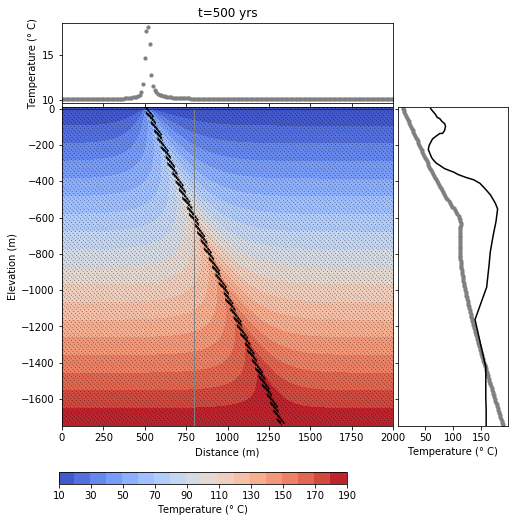

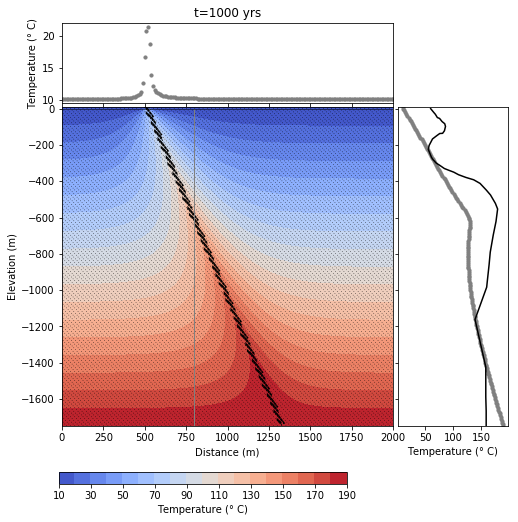

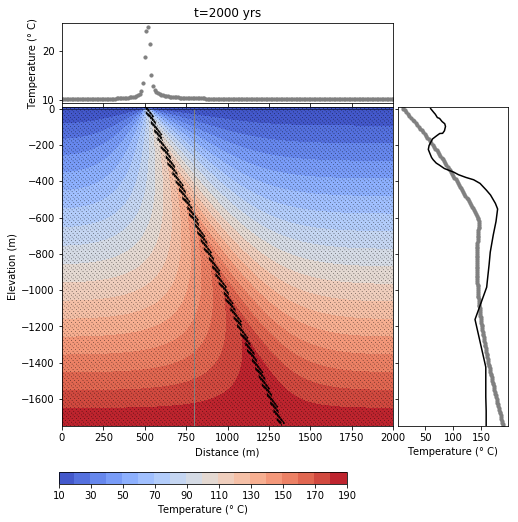

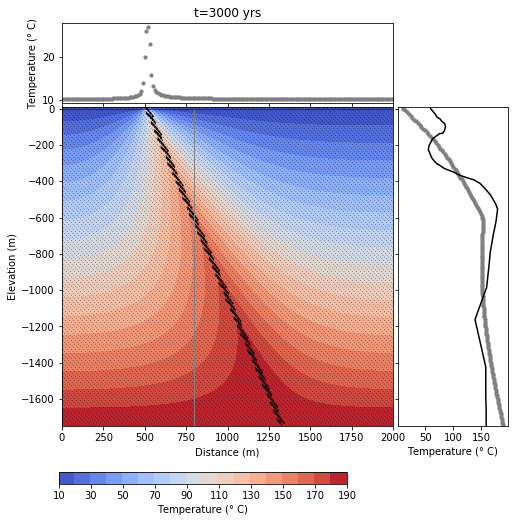

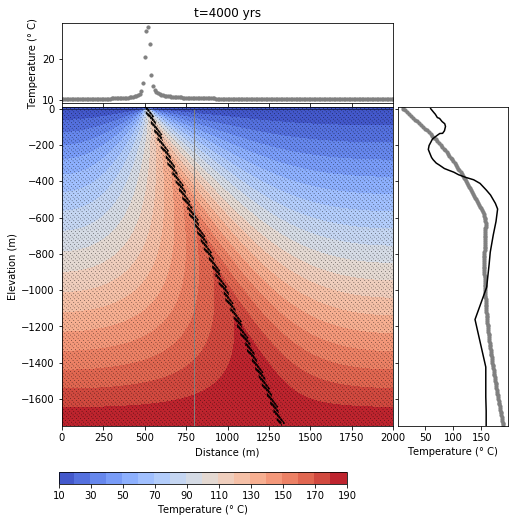

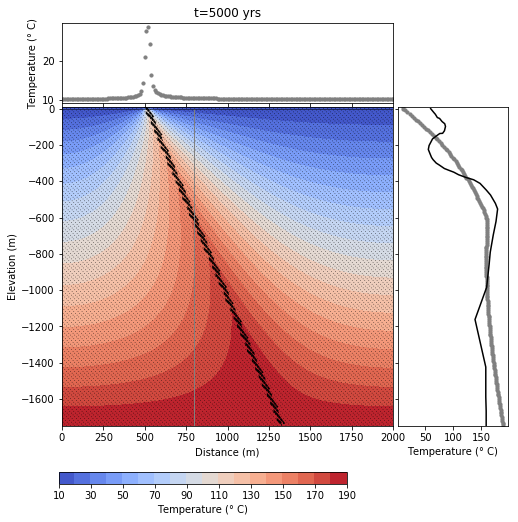

In [27]:
#######################################
# make figures
#######################################
print 'making figures of each timestep'
nt = len(T_array)
vmin = T_array.min()
vmax = T_array.max()

for i, Ta in enumerate(T_array):

    fig = pl.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[3, 1],
                           height_ratios=[1, 4],
                           wspace=0.02, hspace=0.02)

    #
    surf_panel = pl.subplot(gs[0])
    T_panel = pl.subplot(gs[2])
    well_panel = pl.subplot(gs[3])

    # show temperature contours
    contour_intervals = np.arange(vmin, vmax+cnt_int, cnt_int)
    xg, yg, zg = model_functions.interpolate_var_to_2d_grid(xyz_array, Ta)
    leg_cn = T_panel.contourf(xg, yg - subsurface_height, zg.T, contour_intervals, cmap=cmap)

    # show advection
    
    xyv, q_array = model_functions.convert_flux_to_array(q_vector)
    # get absolute flow velocity
    q_abs = (q_array[:, 0]**2 + q_array[:, 1]**2)**0.5
    # set scale for flux vectors in figure:
    scale = np.abs(q_abs).max() * arrow_scale
    # add flow vectors:
    
    qv = T_panel.quiver(xyv[::v_int, 0], xyv[::v_int, 1] - subsurface_height,
                        q_array[::v_int, 0], q_array[::v_int, 1],
                        angles='xy', scale=scale)

    # show well loactions, surface and fault
    T_panel.plot((x_well, x_well), (0, -subsurface_height), color='gray', lw=1.0)
    #T_panel.plot((fault_width, fault_width), (0, -subsurface_height), color='black', lw=0.5)
    T_panel.axhline(y=0, color='black', lw=0.5)

    # show surface temperatures
    surface_nodes = xyz_array[:, 1] == subsurface_height
    surf_panel.scatter(xyz_array[:, 0][surface_nodes],
                       Ta[surface_nodes],
                       color='gray', s=10)

    # show modeled well temperatures
    well_nodes = xyz_array[:, 0] == x_well
    well_panel.scatter(Ta[well_nodes], xyz_array[:, 1][well_nodes] - subsurface_height,
                       color='gray', s=10)

    # show observed well temperatures
    well_panel.plot(T_data['T'], -T_data['depth'], color='black')

    # titles and labels:
    surf_panel.set_title('t=%i yrs' % int(runtimes[i] / year))
    T_panel.set_ylabel('Elevation (m)')
    T_panel.set_xlabel('Distance (m)')
    surf_panel.set_ylabel('Temperature (%s C)' % degree_symbol)
    well_panel.set_xlabel('Temperature (%s C)' % degree_symbol)

    fig.subplots_adjust(bottom=0.18)
    cax = fig.add_axes([0.12, 0.08, 0.5, 0.02])
    cb = fig.colorbar(leg_cn, cax=cax, orientation='horizontal')
    cb.set_label('Temperature (%s C)' % degree_symbol)

    ymin, ymax = xyz_array[:, 1].min() - subsurface_height, xyz_array[:, 1].max() - subsurface_height
    xmin, xmax = xyz_array[:, 0].min(), xyz_array[:, 0].max()

    T_panel.set_xlim(xmin, xmax)
    T_panel.set_ylim(ymin, ymax)

    surf_panel.set_xlim(xmin, xmax)
    well_panel.set_ylim(ymin, ymax)

    surf_panel.set_xticklabels([])
    well_panel.set_yticklabels([])

    fn_fig = 'modeled_T_field_%i_%s_%i.png' % (model_id, today_str, i)
    
    print 'saving figure as %s' % fn_fig
    fig.savefig(fn_fig, dpi=150)

In [28]:
#######################################
# make figures of hydraulic head or flux
#######################################

if simulate_gw_flow is True:

    plot_var = h
    #plot_var = q_vector[0] * year * 1000
    #plot_var = q_vector[1] * year

    label = 'Hydraulic head (m)'
    #label = 'Horizontal flux (m/yr)'
    #label = 'Vertical flux (m/yr)'

    xyz_array, ha = model_functions.convert_to_array(plot_var)
    vmin = ha.min()
    vmax = ha.max()

    Ta = ha

    fig = pl.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[3, 1],
                           height_ratios=[1, 4],
                           wspace=0.02, hspace=0.02)

    #
    surf_panel = pl.subplot(gs[0])
    T_panel = pl.subplot(gs[2])
    well_panel = pl.subplot(gs[3])

    # show temperature contours
    contour_intervals = np.arange(vmin, vmax+cnt_int, cnt_int)
    xg, yg, zg = model_functions.interpolate_var_to_2d_grid(xyz_array, Ta)
    leg_cn = T_panel.contourf(xg, yg - subsurface_height, zg.T, contour_intervals, cmap=cmap)

    # show advection

    xyv, q_array = model_functions.convert_flux_to_array(q_vector)
    # get absolute flow velocity
    q_abs = (q_array[:, 0]**2 + q_array[:, 1]**2)**0.5
    # set scale for flux vectors in figure:
    scale = np.abs(q_abs).max() * arrow_scale
    # add flow vectors:

    qv = T_panel.quiver(xyv[::v_int, 0], xyv[::v_int, 1] - subsurface_height,
                        q_array[::v_int, 0], q_array[::v_int, 1],
                        angles='xy', scale=scale)

    # show well loactions, surface and fault
    T_panel.plot((x_well, x_well), (0, -subsurface_height), color='gray', lw=1.0)
    #T_panel.plot((fault_width, fault_width), (0, -subsurface_height), color='black', lw=0.5)
    T_panel.axhline(y=0, color='black', lw=0.5)

    # show surface temperatures
    surface_nodes = xyz_array[:, 1] == subsurface_height
    surf_panel.scatter(xyz_array[:, 0][surface_nodes],
                       Ta[surface_nodes],
                       color='gray', s=10)

    # show modeled well temperatures
    well_nodes = xyz_array[:, 0] == x_well
    well_panel.scatter(Ta[well_nodes], xyz_array[:, 1][well_nodes] - subsurface_height,
                       color='gray', s=10)

    # show observed well temperatures
    #well_panel.plot(T_data['T'], -T_data['depth'], color='black')

    # titles and labels:
    #surf_panel.set_title('t=%i yrs' % int(runtimes[i] / year))
    T_panel.set_ylabel('Elevation (m)')
    T_panel.set_xlabel('Distance (m)')
    surf_panel.set_ylabel(label)
    well_panel.set_xlabel(label)

    fig.subplots_adjust(bottom=0.18)
    cax = fig.add_axes([0.12, 0.08, 0.5, 0.02])
    cb = fig.colorbar(leg_cn, cax=cax, orientation='horizontal')
    cb.set_label(label)

    ymin, ymax = xyz_array[:, 1].min() - subsurface_height, xyz_array[:, 1].max() - subsurface_height
    xmin, xmax = xyz_array[:, 0].min(), xyz_array[:, 0].max()

    T_panel.set_xlim(xmin, xmax)
    T_panel.set_ylim(ymin, ymax)

    surf_panel.set_xlim(xmin, xmax)
    well_panel.set_ylim(ymin, ymax)

    surf_panel.set_xticklabels([])
    well_panel.set_yticklabels([])

    fn_fig = 'modeled_h_or_flux_%i_%s.png' % (model_id, today_str)

    print 'saving figure as %s' % fn_fig
    fig.savefig(fn_fig, dpi=150)